# Contents and why we need this lab

This lab is about implementing neural networks yourself before we start using other frameworks that hide some of the computation from you. It builds on the first lab, where you derived the equations for neural network forward and backward propagation and gradient descent parameter updates.

All the frameworks for deep learning you will meet from now on use automatic differentiation (autodiff), so you do not have to code the backward step yourself. In this version of this lab, you will develop your own autodif implementation. We also have an optional [version](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/2_Feedforward_Python/2.2-FNN-NumPy.ipynb) of this lab where you have to code the backward pass explicitly in Numpy.

# External sources of information

1. Jupyter notebook. You can find more information about Jupyter notebooks [here](https://jupyter.org/). It will come as part of the [Anaconda](https://www.anaconda.com/) Python installation.
2. [NumPy](https://numpy.org/). Part of Anaconda distribution.  If you already know how to program, most things about Python and NumPy can be found with Google searches.
3. [Nanograd](https://github.com/rasmusbergpalm/nanograd) is a minimalistic version of autodiff developed by Rasmus Berg Palm that we use for our framework.


# This notebook will follow the next steps:

1. Nanograd automatic differentiation framework
2. Finite difference method
3. Data generation
4. Defining and initializing the network
5. Forward pass
6. Training loop
7. Testing your model
8. Further extensions

# Nanograd automatic differention framework

The [Nanograd](https://github.com/rasmusbergpalm/nanograd) framework defines a class Var which both holds a value and gradient value that we can use to store the intermediate values when we apply the chain rule of differentiation.

In [ ]:
# Copy and pasted from https://github.com/rasmusbergpalm/nanograd/blob/3a1bf9e9e724da813bfccf91a6f309abdade9f39/nanograd.py

from math import exp, log

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

A few examples illustrate how we can use this:

In [ ]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

for v in [a, b, f]:
    print(v)

Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


In [ ]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)


## Exercise a) What is being calculated?

Explain briefly the output of the code? What is the expression we differentiate and with respect to what variables?

## **Solution to exercise a:**
The output of the code is a representation of the weight of a node in an neural network. We differentiate with respect to the nodes in the neural network. This is further illustrated in the solution to exercise B3.

## Exercise b) How does the backward function work?

You need to understand how the backward function calculates the gradients. We can use the two examples above to help with that.

Go through the following four steps and answer the questions on the way:

1. We represent the two expressions as graphs as shown below. Fill in the missing expressions for the different derivatives.

2. In the remainder consider the first expression. Make a schematic of the data structure which is generated when we define the expression for f.

3. Then execute the backward function by hand to convince yourself that it indeed calculates the gradients with respect to the variables.

4. Write down the sequence of calls to backprop.



## **Solution to exercise b:**

### **Solution for exercise b.1**

In [ ]:
# import logging
import graphviz

#logging.basicConfig(format='[%(levelname)s@%(name)s] %(message)s', level=logging.DEBUG)

#graphviz.__version__, graphviz.version()

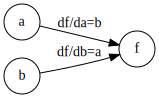

In [ ]:
e1 = graphviz.Digraph('first expression', filename='fsm.gv')

e1.attr(rankdir='LR', size='8,5')

e1.attr('node', shape='circle')
e1.edge('a', 'f', label='df/da=b')
e1.edge('b', 'f', label='df/db=a')

e1

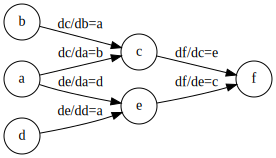

In [ ]:
e2 = graphviz.Digraph('second expression', filename='fsm.gv')

e2.attr(rankdir='LR', size='8,5')

e2.attr('node', shape='circle')
e2.edge('a', 'c', label='dc/da=b')
e2.edge('b', 'c', label='dc/db=a')
e2.edge('a', 'e', label='de/da=d')
e2.edge('d', 'e', label='de/dd=a')
e2.edge('c', 'f', label='df/dc=e')
e2.edge('e', 'f', label='df/de=c')

e2

### **Solution to exercise b.2**

$$
f = (a_v \cdot b_v, \mathrm{lambda}: [(a, b_v), (b, a_v)]) = (15, \mathrm{lambda}: [(a, 5), (b, 3)])
$$

### **Solution to exercise b.3**
Below, I have derives expressions for the gradient of each node in the first expression:

$$
a_{grad} = \frac{\partial f}{\partial a} = \frac{\partial }{\partial a} (b \cdot a) = b
$$
$$
b_{grad} = \frac{\partial f}{\partial b} = \frac{\partial }{\partial b} (b \cdot a) = a
$$
$$
f_{grad} = \frac{\partial f}{\partial f} = 1
$$

### **Solution to exercise b.4**



In [ ]:
a = Var(3.0)
b = Var(5.0)
f = a * b

f.backward()

print("Output from example:")
for v in [a, b, f]:
    print(v)

Output from example:
Var(v=3.0000, grad=5.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)


**Outlined calculations**:

1. Object $a$ is defined with value $v_a = 3$ and gradient $\delta_a = 0$.
2. Object $b$ is defined with value $v_b = 5$ and gradient $\delta_b = 0$.
3. Object $f$ is defined with value $v_f = v_a \cdot v_b$ = 15, and gradient $\delta_f = 0$. In addition, the node is connected to $a$ and $b$ with an array of tuples, connecting a node with the corresponding gradient being the value of the other connected node in the format $[(node, \delta), ...]$. In case of $f$, the tuple will be $[(a, v_b), (b, v_a)]$
4. Backpropagation is called on $f$, updating the gradient $\delta_f = 1$
5. Backpropagation is then called recursively to the connected nodes to $f$, being $a$ and $b$, with the value $bp \cdot \delta$ as argument.
6. In each recursive call, the gradient for each object is updated by adding the argument $bp \cdot \delta$ to the gradient property of the object. So for $a$, $\delta_a = 0 + 1 \cdot 5$ and for $b$, $\delta_b = 0 + 1 \cdot 3$, which corresponds to the output of the script.

## Exercise c) What happens if we run backward again?

Try to execute the code below. Explain what happens.

In [ ]:
f.backward()

for v in [a, b, c, d, e, f]:
    print(v)

Var(v=3.0000, grad=10.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=15.0000, grad=2.0000)


## **Solution for exercise c:**


In [ ]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()
print("First iteration.")
for v in [a, b, c, d, e, f]:
    print(v)
print()

# run again!
f.backward()
print("Second iteration")
for v in [a, b, c, d, e, f]:
    print(v)

First iteration.
Var(v=3.0000, grad=14.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)

Second iteration
Var(v=3.0000, grad=28.0000)
Var(v=5.0000, grad=6.0000)
Var(v=15.0000, grad=2.0000)
Var(v=9.0000, grad=6.0000)
Var(v=27.0000, grad=2.0000)
Var(v=42.0000, grad=2.0000)


Since the values for each object does not change, and the gradients added to the gradient attribute of the objects are simply added to the existing value, as per the "self.grad += bp" term in the backprop-function. For example, for $a$, the gradient attribute will be incremented by 14 for each iteration of calling the backward-function.

## Exercise d) Zero gradient

We can zero the gradient by backpropagating a -1.0 as is shown in the example below. (If you have run backward multiple time then you also have to run the cell below an equal amount of times.) Explain what is going on.

In [ ]:
a = Var(3.0)
b = Var(5.0)
c = a * b
d = Var(9.0)
e = a * d
f = c + e

f.backward()

a = Var(2.0)
print("Var 2.0")
for v in [a, b, c, d, e, f]:
    print(v)

print("\nbp set to -1")
f.backprop(-1.0)

for v in [a, b, c, d, e, f]:
    print(v)

Var 2.0
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=3.0000)
Var(v=15.0000, grad=1.0000)
Var(v=9.0000, grad=3.0000)
Var(v=27.0000, grad=1.0000)
Var(v=42.0000, grad=1.0000)

bp set to -1
Var(v=2.0000, grad=0.0000)
Var(v=5.0000, grad=0.0000)
Var(v=15.0000, grad=0.0000)
Var(v=9.0000, grad=0.0000)
Var(v=27.0000, grad=0.0000)
Var(v=42.0000, grad=0.0000)


## **Solution to exercise d:**
Similarly to the above, when $bp = -1$ is introduced in backwards, the calculated magnitude is subtracted rather than added in the same fashion as explained in exercise c.

## Exercise e) Test correctness of derivatives with the finite difference method

Write a small function that uses [the finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) to numerically test that backpropation implementation is working. In short we will use
$$
\frac{\partial f(a)}{\partial a} \approx \frac{f(a+da)-f(a)}{da}
$$
for $da \ll 1$.

As an example, we could approximate the derivative of the function $f(a)=a^2$ in e.g. the value $a=4$ using the finite difference method. This amounts to inserting the relevant values and approximating the gradient $f'(4)$ with the fraction above.

## **Solution to exercise e**

In [11]:
# f function - try to change the code to test other types of functions as well (such as different polynomials etc.)
def f_function(a):
  a = Var(a)
  b = Var(5.0)
  f = a ** 2  # <- change this function at your own whim!
  f.backward()
  return a,b,f

for v in f_function(3.0):
  print(v)

# Insert your finite difference code here
def finite_difference(da=1e-10):
    """
    This function compute the finite difference between

    Input:
    da:          The finite difference                           (float)

    Output:
    finite_difference: numerical approximation to the derivative (float)
    """
    a = 4.0 # <- change the value for a here!
    _, _, fa_da = f_function(a + da)          # <- Insert correct expression
    a_var, _, fa = f_function(a)              # <- Insert correct expression

    finite_difference = (fa_da - fa).v / da

    print(f"Actual gradient for a: {a_var.grad}")

    return finite_difference

print(f"Finite difference gradient approximation for a: {finite_difference()}")

Var(v=3.0000, grad=6.0000)
Var(v=5.0000, grad=0.0000)
Var(v=9.0000, grad=1.0000)
Actual gradient for a: 8.0
Finite difference gradient approximation for a: 8.000000661922968


We see in the example above, that approximated- and actual value for the gradient of $a$ match. The example above is setup for $f(a)=a^2, \; a=4$. However, the f variable can be changed into other functions (polynomials, etc.).

# Create an artificial dataset to play with

We create a non-linear 1d regression task. The generator supports various noise levels and it creates train, validation and test sets. You can modify it yourself if you want more or less challenging tasks.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [13]:
def data_generator(noise=0.1, n_samples=300, D1=True):
    # Create covariates and response variable
    if D1:
        X = np.linspace(-3, 3, num=n_samples).reshape(-1,1) # 1-D
        np.random.shuffle(X)
        y = np.random.normal((0.5*np.sin(X[:,0]*3) + X[:,0]), noise) # 1-D with trend
    else:
        X = np.random.multivariate_normal(np.zeros(3), noise*np.eye(3), size = n_samples) # 3-D
        np.random.shuffle(X)
        y = np.sin(X[:,0]) - 5*(X[:,1]**2) + 0.5*X[:,2] # 3-D

    # Stack them together vertically to split data set
    data_set = np.vstack((X.T,y)).T

    train, validation, test = np.split(data_set, [int(0.35*n_samples), int(0.7*n_samples)], axis=0)

    # Standardization of the data, remember we do the standardization with the training set mean and standard deviation
    train_mu = np.mean(train, axis=0)
    train_sigma = np.std(train, axis=0)

    train = (train-train_mu)/train_sigma
    validation = (validation-train_mu)/train_sigma
    test = (test-train_mu)/train_sigma

    x_train, x_validation, x_test = train[:,:-1], validation[:,:-1], test[:,:-1]
    y_train, y_validation, y_test = train[:,-1], validation[:,-1], test[:,-1]

    return x_train, y_train,  x_validation, y_validation, x_test, y_test

In [14]:
D1 = True
x_train, y_train,  x_validation, y_validation, x_test, y_test = data_generator(noise=0.5, D1=D1)

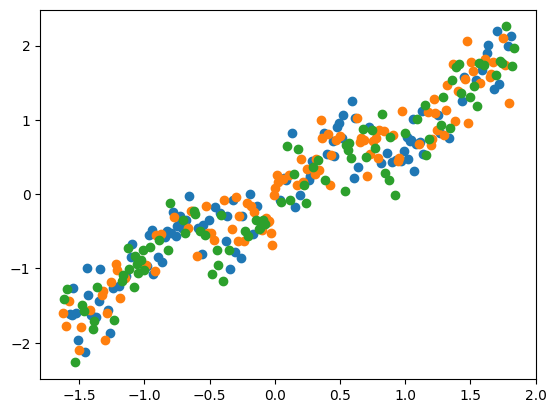

In [15]:
if D1:
    plt.scatter(x_train[:,0], y_train);
    plt.scatter(x_validation[:,0], y_validation);
    plt.scatter(x_test[:,0], y_test);
else:
    plt.scatter(x_train[:,1], y_train);
    plt.scatter(x_validation[:,1], y_validation);
    plt.scatter(x_test[:,1], y_test);
plt.show()

In [16]:
# convert from nparray to Var
def nparray_to_Var(x):
  if x.ndim==1:
    y = [[Var(float(x[i]))] for i in range(x.shape[0])] # always work with list of list
  else:
    y = [[Var(float(x[i,j])) for j in range(x.shape[1])] for i in range(x.shape[0])]
  return y

x_train = nparray_to_Var(x_train)
y_train = nparray_to_Var(y_train)
x_validation = nparray_to_Var(x_validation)
y_validation = nparray_to_Var(y_validation)
x_test = nparray_to_Var(x_test)
y_test = nparray_to_Var(y_test)


# Defining and initializing the network

The steps to create a feed forward neural network are the following:

1. **Number of hidden layer and hidden units**. We have to define the number of hidden units in each layer. The number of features in X and the output dimensionality (the size of Y) are given but the numbers in between are set by the researcher. Remember that for each unit in each layer beside in the input has a bias term.
2. **Activation functions** for each hidden layer. Each hidden layer in your list must have an activation function (it can also be the linear activation which is equivalent to identity function). The power of neural networks comes from non-linear activation functions that learn representations (features) from the data allowing us to learn from it.
3. **Parameter initialization**. We will initialize the weights to have random values. This is done in practice by drawing pseudo random numbers from a Gaussian or uniform distribution. It turns out that for deeper models we have to be careful about how we scale the random numbers. This will be the topic of the exercise below. For now we will just use unit variance Gaussians.  

In order to make life easier for ourselves we define a DenseLayer class that takes care of initialization and the forward pass. We can also extend it later with print and advanced initialization capabilities. For the latter we have introduced a Initializer class.

Note that we use Sequence in the code below. A Sequence is an ordered list. This means the order we insert and access items are the same.

In [17]:
class Initializer:

  def init_weights(self, n_in, n_out):
    raise NotImplementedError

  def init_bias(self, n_out):
    raise NotImplementedError

In [18]:
import random

class NormalInitializer(Initializer):

  def __init__(self, mean=0, std=0.1):
    self.mean = mean
    self.std = std

  def init_weights(self, n_in, n_out):
    return [[Var(random.gauss(self.mean, self.std)) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(0.0) for _ in range(n_out)]

class ConstantInitializer(Initializer):

  def __init__(self, weight=1.0, bias=0.0):
    self.weight = weight
    self.bias = bias

  def init_weights(self, n_in, n_out):
    return [[Var(self.weight) for _ in range(n_out)] for _ in range(n_in)]

  def init_bias(self, n_out):
    return [Var(self.bias) for _ in range(n_out)]

In [19]:
from typing import Sequence

class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            node = Var(0.0) # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += single_input[i] * weights[i][j]  # <- Insert code
            node += self.bias[j]
            node = self.act_fn(node)
            out.append(node)

        return out

## Exercise f) Add more activation functions

To have a full definition of the neural network, we must define an activation function for every layer. Several activation functions have been proposed and have different characteristics. In the Var class we have already defined the rectified linear init (relu).

Implement the following activation functions in the Var class:

* Identity: $$\mathrm{identity}(x) = x$$
* Hyperbolic tangent: $$\tanh(x)$$
* Sigmoid (or logistic function): $$\mathrm{sigmoid}(x) = \frac{1}{1.0 + \exp(-x ) }$$  Hint: $\mathrm{sigmoid}'(x)= \mathrm{sigmoid}(x)(1-\mathrm{sigmoid}(x))$.  

Hint: You can seek inspiration in the relu method in the Var class.

## **Solution to exercise f**

In [20]:
from math import exp, log, tanh

class Var:
    """
    A variable which holds a float and enables gradient computations.
    """

    def __init__(self, val: float, grad_fn=lambda: []):
        assert type(val) == float
        self.v = val
        self.grad_fn = grad_fn
        self.grad = 0.0

    def backprop(self, bp):
        self.grad += bp
        for input, grad in self.grad_fn():
            input.backprop(grad * bp)

    def backward(self):
        self.backprop(1.0)

    def __add__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v + other.v, lambda: [(self, 1.0), (other, 1.0)])

    def __mul__(self: 'Var', other: 'Var') -> 'Var':
        return Var(self.v * other.v, lambda: [(self, other.v), (other, self.v)])

    def __pow__(self, power):
        assert type(power) in {float, int}, "power must be float or int"
        return Var(self.v ** power, lambda: [(self, power * self.v ** (power - 1))])

    def __neg__(self: 'Var') -> 'Var':
        return Var(-1.0) * self

    def __sub__(self: 'Var', other: 'Var') -> 'Var':
        return self + (-other)

    def __truediv__(self: 'Var', other: 'Var') -> 'Var':
        return self * other ** -1

    def __repr__(self):
        return "Var(v=%.4f, grad=%.4f)" % (self.v, self.grad)

    def relu(self):
        return Var(self.v if self.v > 0.0 else 0.0, lambda: [(self, 1.0 if self.v > 0.0 else 0.0)])

    def identity(self):
        return Var(self.v, lambda: [(self, self.v)])

    def tanh(self):
        return Var(tanh(self.v), lambda: [(self, tanh(self.v))])

    def sigmoid(self):
        return Var(1 / (1.0 + exp(-self.v)), lambda: [(self, 1 / (1.0 + exp(-self.v)))])

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])

    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

test = Var(5.0)
print(f"Identity: {test.identity()}")
print(f"Tanh: {test.tanh()}")
print(f"Sigmoid: {test.sigmoid()}")

Identity: Var(v=5.0000, grad=0.0000)
Tanh: Var(v=0.9999, grad=0.0000)
Sigmoid: Var(v=0.9933, grad=0.0000)


In the above, modified implementation of the "Var" class, the identity, tanh, and sigmoid function is implemented in a similar fashion to the pre-existing ReLU activation function implementation.

## Exercise g) Complete the forward pass

In the code below we initialize a 1-5-1 network and pass the training set through it. *The forward method in DenseLayer is **not** complete*. It just outputs zeros right now. The method forward should perform an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) on the input followed by an application of the activation function.

In [21]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))


[[Var(v=-0.0165, grad=0.0000)], [Var(v=-0.0332, grad=0.0000)], [Var(v=-0.0030, grad=0.0000)], [Var(v=-0.0674, grad=0.0000)], [Var(v=-0.0245, grad=0.0000)], [Var(v=-0.0226, grad=0.0000)], [Var(v=-0.0147, grad=0.0000)], [Var(v=-0.0162, grad=0.0000)], [Var(v=-0.0695, grad=0.0000)], [Var(v=-0.0091, grad=0.0000)], [Var(v=-0.0255, grad=0.0000)], [Var(v=-0.0429, grad=0.0000)], [Var(v=-0.0205, grad=0.0000)], [Var(v=-0.0490, grad=0.0000)], [Var(v=-0.0110, grad=0.0000)], [Var(v=-0.0213, grad=0.0000)], [Var(v=-0.0393, grad=0.0000)], [Var(v=-0.0186, grad=0.0000)], [Var(v=-0.0020, grad=0.0000)], [Var(v=-0.0065, grad=0.0000)], [Var(v=-0.0321, grad=0.0000)], [Var(v=-0.0142, grad=0.0000)], [Var(v=-0.0287, grad=0.0000)], [Var(v=-0.0290, grad=0.0000)], [Var(v=-0.0188, grad=0.0000)], [Var(v=-0.0505, grad=0.0000)], [Var(v=-0.0372, grad=0.0000)], [Var(v=-0.0409, grad=0.0000)], [Var(v=-0.0043, grad=0.0000)], [Var(v=-0.0258, grad=0.0000)], [Var(v=-0.0633, grad=0.0000)], [Var(v=-0.0062, grad=0.0000)], [Var(v=

## **Solution to exercise g**


In [22]:
class DenseLayer:
    def __init__(self, n_in: int, n_out: int, act_fn, initializer = NormalInitializer()):
        self.weights = initializer.init_weights(n_in, n_out)
        self.bias = initializer.init_bias(n_out)
        self.act_fn = act_fn

    def __repr__(self):
        return 'Weights: ' + repr(self.weights) + ' Biases: ' + repr(self.bias)

    def parameters(self) -> Sequence[Var]:
      params = []
      for r in self.weights:
        params += r

      return params + self.bias

    def forward(self, single_input: Sequence[Var]) -> Sequence[Var]:
        # self.weights is a matrix with dimension n_in x n_out. We check that the dimensionality of the input
        # to the current layer matches the number of nodes in the current layer
        assert len(self.weights) == len(single_input), "weights and single_input must match in first dimension"
        weights = self.weights
        out = []
        # For some given data point single_input, we now want to calculate the resulting value in each node in the current layer
        # We therefore loop over the (number of) nodes in the current layer:
        for j in range(len(weights[0])):
            # Initialize the node value depending on its corresponding parameters.
            node = self.bias[j] # node = Var(0.0) # <- Insert code
            # We now finish the linear transformation corresponding to the parameters of the currently considered node.
            for i in range(len(single_input)):
                node += weights[i][j] * single_input[i] # node += Var(0.0)  # <- Insert code
            node = self.act_fn(node)
            out.append(node)

        return out


In [23]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

def forward(input, network):

  def forward_single(x, network):
    for layer in network:
        x = layer.forward(x)
    return x

  output = [ forward_single(input[n], network) for n in range(len(input))]
  return output

print(forward(x_train, NN))

[[Var(v=-0.0002, grad=0.0000)], [Var(v=-0.0004, grad=0.0000)], [Var(v=-0.0000, grad=0.0000)], [Var(v=0.0111, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=-0.0002, grad=0.0000)], [Var(v=0.0027, grad=0.0000)], [Var(v=0.0114, grad=0.0000)], [Var(v=-0.0001, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=0.0070, grad=0.0000)], [Var(v=-0.0002, grad=0.0000)], [Var(v=0.0081, grad=0.0000)], [Var(v=-0.0001, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=-0.0005, grad=0.0000)], [Var(v=-0.0002, grad=0.0000)], [Var(v=-0.0000, grad=0.0000)], [Var(v=-0.0001, grad=0.0000)], [Var(v=0.0053, grad=0.0000)], [Var(v=0.0023, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=-0.0004, grad=0.0000)], [Var(v=0.0031, grad=0.0000)], [Var(v=0.0083, grad=0.0000)], [Var(v=-0.0005, grad=0.0000)], [Var(v=-0.0005, grad=0.0000)], [Var(v=-0.0001, grad=0.0000)], [Var(v=-0.0003, grad=0.0000)], [Var(v=0.0104, grad=0.0000)], [Var(v=-0.0001, grad=0.0000)], [Var(v=0.0091, gr

In the above implementation of the "DenseLayer" class, the forward-function has been modified to perform an "affine transformation by adding bias and sum of weights and inputs.

## Exercise h) Print all network parameters

Make a function that prints all the parameters of the network (weights and biases) with information about in which layer the appear. In the object oriented spirit you should introduce a method in the DenseLayer class to print the parameters of a layer. Hint: You can take inspiration from the corresponding method in Var.

## **Solution to exercise h:**

In [24]:
# Function that outputs weights and biases for each layer
def print_network_params(network):
    for layer_idx, layer in enumerate(network):
        print(f"Layer {layer_idx + 1} Parameters:")
        print(layer)

print_network_params(NN)

Layer 1 Parameters:
Weights: [[Var(v=-0.0383, grad=0.0000), Var(v=-0.0629, grad=0.0000), Var(v=-0.0242, grad=0.0000), Var(v=0.0317, grad=0.0000), Var(v=-0.1228, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000), Var(v=0.0000, grad=0.0000)]
Layer 2 Parameters:
Weights: [[Var(v=0.0121, grad=0.0000)], [Var(v=0.0059, grad=0.0000)], [Var(v=0.0877, grad=0.0000)], [Var(v=-0.0087, grad=0.0000)], [Var(v=0.0352, grad=0.0000)]] Biases: [Var(v=0.0000, grad=0.0000)]


## Visualization

Now that we have defined our activation functions we can visualize them to see what they look like:

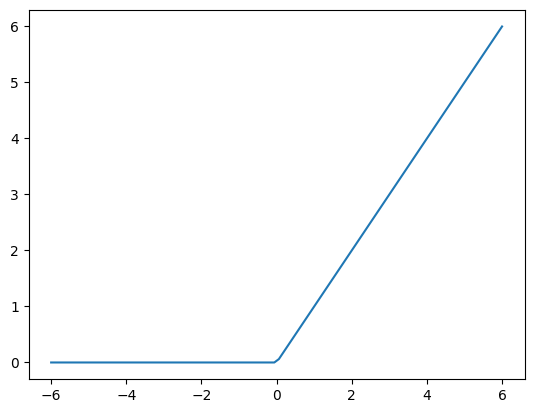

In [25]:
x = np.linspace(-6, 6, 100)

# convert from Var to ndarray
def Var_to_nparray(x):
  y = np.zeros((len(x),len(x[0])))
  for i in range(len(x)):
    for j in range(len(x[0])):
      y[i,j] = x[i][j].v
  return y

# define 1-1 network with weight = 1 and relu activation
NN = [ DenseLayer(1, 1, lambda x: x.relu(), initializer = ConstantInitializer(1.0)) ]
y = Var_to_nparray(forward(nparray_to_Var(x), NN))

#y = Var_to_nparray(relu(nparray_to_Var(x)))
plt.plot(x,y)

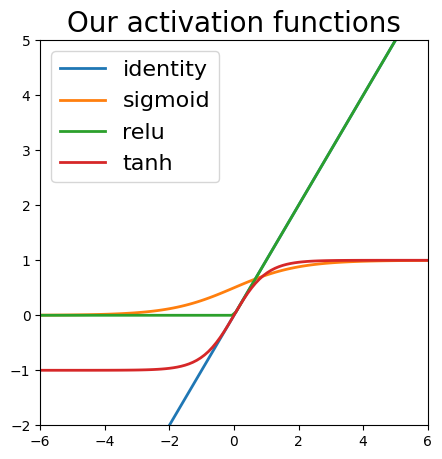

In [26]:
# Testing all activation layers

x = np.linspace(-6, 6, 100)
units = {
    "identity": lambda x: x.identity(),
    "sigmoid": lambda x: x.sigmoid(),
    "relu": lambda x: x.relu(),
    "tanh": lambda x: x.tanh()
}

plt.figure(figsize=(5, 5))
[plt.plot(x, Var_to_nparray(forward(nparray_to_Var(x), [DenseLayer(1, 1, unit, initializer = ConstantInitializer(1.0))]) ), label=unit_name, lw=2) for unit_name, unit in units.items()] # unit(nparray_to_Var(x))), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Our activation functions', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])
plt.show()

# Advanced initialization schemes

If we are not careful with initialization, the signals we propagate forward ($a^{(l)}$, $l=1,\ldots,L$) and backward ($\delta^l$, $l=L,L-1,\ldots,1$) can blow up or shrink to zero. A statistical analysis of the variance of the signals for different activation functions can be found in these two papers: [Glorot initialization](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) and [He initialization](https://arxiv.org/pdf/1502.01852v1.pdf).

The result of the analyses are proposals for how to make the initialization such that the variance of the signals (forward and backward) are kept approxmimatly constant when propagating from layer to layer. The exact expressions depend upon the non-linear activation function used. In Glorot initialization, the aim is to keep both the forward and backward variances constant whereas He only aims at keeping the variance in the forward pass constant.

We define $n_{in}$ and $n_{out}$ as the number of input units and output units of a particular layer.

The Glorot initialization has the form:

$$w_{ij} \sim N \bigg( 0, \, \frac{2 \alpha }{n_{in} + n_{out}} \bigg) \ . $$

where $N(\mu,\sigma^2)$ is a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and $\alpha$ is a parameter that depends upon the activation function used. For $\tanh$, $\alpha=1$ and for Rectified Linear Unit (ReLU) activations, $\alpha=2$. (It is also possible to use a uniform distribution for initialization, see [this blog post](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).)

The He initialization is very similar

$$w_{ij} \sim N \bigg( 0, \, \frac{\alpha}{n_{in}} \bigg) \ . $$

## Exercise i) Glorot and He initialization

Using the Initializer class, implement functions that implement Glorot and He

Explain briefly how you would test numerically that these initializations have the sought after property. Hint: See plots in Glorot paper.

Comment: If you want to be more advanced then try to make a universal initializer taking both the activation function and type (Glorot or He) as argument.

## **Solution to exercise i:**

In [27]:
## Glorot
def DenseLayer_Glorot_tanh(n_in: int, n_out: int):
  alpha = 1.0 # tanh activation -> alpha = 1.0
  std = ((2.0*alpha)/(n_in + n_out))**0.5 # std = 0.0 # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.tanh(), initializer = NormalInitializer(std))

## He
def DenseLayer_He_relu(n_in: int, n_out: int):
  alpha = 2.0 # ReLU activation -> alpha = 2.0
  std = (alpha/n_in)**0.5 # std = 0.0 # <- replace with proper initialization
  return DenseLayer(n_in, n_out, lambda x: x.relu(), initializer = NormalInitializer(std))

In the above example, standard deviation is used in the random.gauss function, which takes standard deviation as argument, not variance.
I would test the initialization by initializing the network with these initializers, and look at the distribution of the activation values, as shown in the Glorot paper. The distribution should be a Gaussian distribution.

## Exercise j) Forward pass unit test

Write a bit of code to make a unit test that the forward pass works. This can be done by defining a simple network with for example all weights equal to one (using the ConstantInitializer method) and identity activation functions.

Hints: Use the [assert](https://www.w3schools.com/python/ref_keyword_assert.asp), the nparray_to_Var and the Var_to_nparray commands.

## **Solution to exercise j**

In [28]:
# Insert code here
# write a unit test for the forward pass of the network

def test_forward():
    # arrange
    hidden_nodes = 5
    NN = [
        DenseLayer(1, hidden_nodes, lambda x: x.identity(), initializer=ConstantInitializer(1.0)),
        DenseLayer(hidden_nodes, 1, lambda x: x.identity(), initializer=ConstantInitializer(1.0))
    ]

    # act
    x_sample = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
    actual_output = Var_to_nparray(forward(nparray_to_Var(x_sample), NN))

    # assert
    expected_output = hidden_nodes * x_sample

    print(f"Expected output: {expected_output}")
    print(f"Actual output: {actual_output.reshape(-1)}")
    assert np.all(actual_output.reshape(-1) == expected_output), "The forward pass is not correct"

test_forward()

Expected output: [ 5. 10. 15. 20. 25.]
Actual output: [ 5. 10. 15. 20. 25.]


For this unit test, I have implemented a simple unit test in the AAA format. Here, we have initialized a network with 5 hidden nodes, initialized using theConstantInitializer method to set all network weights to 1. In addition the identity activation function is used for each layer. Knowing how the forward function works from previous exercises, we would expect this NN to multiply each element in the input sample by the number of hidden units in the NN. Therefore, the unit test is setup to test this property by comparing the expected- and actual output elementwise. The code-snippet about will execute successfully, if the comparison evaluates to true.

In actuality, this unit test should test for multiple hidden unit numbers, as a trend cannot be indicated by 1 sample.

# Loss functions

We are only missing a loss function to we need to define a loss function and its derivative with respect to the output of the neural network $y$

In [29]:
def squared_loss(t, y):

  # add check that sizes agree

  def squared_loss_single(t, y):
    Loss = Var(0.0)
    for i in range(len(t)): # sum over outputs
      Loss += (t[i]-y[i]) ** 2
    return Loss

  Loss = Var(0.0)
  for n in range(len(t)): # sum over training data
    Loss += squared_loss_single(t[n],y[n])
  return Loss

## Exercise k) Implement cross entropy loss

Insert code below to implement cross-entropy loss for general dimensionality of $t$. Use a logits formulation:
$$
\rm{Loss} = - \sum_i t_i \, log \, p_i
$$
with $p$ given by the the softmax function in terms of the logits $h$:
$$
p_i = \frac{\exp(h_i)}{\sum_{i'} \exp(h_{i'})} .
$$
Inserting $p$ in the expression for the loss gives
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
where
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This is true for $t$ being a one-hot vector.

Call the function to convince yourself it works.

In practice you want to implement a [numerically stable](https://leimao.github.io/blog/LogSumExp/) version of LogSumExp. But we will not bother about that here.

Help: You can add these methods in the Var class:

    def exp(self):
        return Var(exp(self.v), lambda: [(self, exp(self.v))])
    
    def log(self):
        return Var(log(self.v), lambda: [(self, self.v ** -1)])

## **Solution to exercise k**

In [30]:
def cross_entropy_loss(t, h):

    def cross_entropy_loss_single(t, h):

        def log_sum_exp(h):
            Loss = Var(0.0)
            for h_i in h:
                Loss += h_i.exp()
            return Loss.log()

        Loss = Var(0.0)
        for i in range(len(t)): # sum over outputs
            Loss += t[i] * h[i]
        return log_sum_exp(h) - Loss # add LogSumExp(h) and subtract the sum of t_i and h_i

    Loss = Var(0.0)
    for n in range(len(t)): # sum over training data
        Loss += cross_entropy_loss_single(t[n],h[n])
    return Loss


Similarly to the squared loss function, we can keep the same structure for the cross entropy loss function, and add the the terms
$$
\rm{Loss} = - \sum_i t_i h_i + \rm{LogSumExp}(h) \ ,
$$
and
$$
\rm{LogSumExp}(h) = \log \sum_i \exp h_i \ .
$$
This way, we have an implementation that can be used interchangably with the squared loss function. To convince myself that the function works, it is called in the Backward pass code snippet  below.

# Backward pass

Now the magic happens! We get the calculation of the gradients for free. Just do:

In [53]:
NN = [
    DenseLayer(1, 5, lambda x: x.relu()),
    DenseLayer(5, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = cross_entropy_loss(y_train,output) # Look! Cross-entropy loss is used here
Loss.backward()

and the gradients will be calculated:

In [54]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

Layer 0 
 Weights: [[Var(v=-0.0935, grad=-0.0290), Var(v=-0.1186, grad=-0.0601), Var(v=0.1501, grad=-0.0071), Var(v=-0.0787, grad=0.0756), Var(v=0.0963, grad=-0.0166)]] Biases: [Var(v=0.0000, grad=0.0249), Var(v=0.0000, grad=0.0515), Var(v=0.0000, grad=-0.0021), Var(v=0.0000, grad=-0.0648), Var(v=0.0000, grad=-0.0049)]
Layer 1 
 Weights: [[Var(v=0.0444, grad=0.0612)], [Var(v=0.0919, grad=0.0776)], [Var(v=-0.0356, grad=0.0301)], [Var(v=-0.1156, grad=0.0515)], [Var(v=-0.0824, grad=0.0193)]] Biases: [Var(v=0.0000, grad=0.6204)]


[None, None]

# Backward pass unit test

Above we used finite differences to test that Nanograd is actually doing what it is supposed to do. We can in principle try the same for the neural network. But we will trust that the test above is enough.

# Training and validation

We are ready to train some neural networks!

We initialize again:

In [32]:
NN = [
    DenseLayer(1, 15, lambda x: x.relu()),
    DenseLayer(15, 50, lambda x: x.relu()),
    DenseLayer(50, 1, lambda x: x.identity())
]

output = forward(x_train, NN)

Loss = squared_loss(y_train,output)
Loss.backward()

and make an update:

We introduce a help function parameters to have a handle in all parameters in the network.

In [ ]:
print('Network before update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

def parameters(network):
  params = []
  for layer in range(len(network)):
    params += network[layer].parameters()
  return params

def update_parameters(params, learning_rate=0.01):
  for p in params:
    p.v -= learning_rate*p.grad

def zero_gradients(params):
  for p in params:
    p.grad = 0.0

update_parameters(parameters(NN))

print('\nNetwork after update:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

zero_gradients(parameters(NN))

print('\nNetwork after zeroing gradients:')
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))]

In [45]:
# Initialize an arbitrary neural network
NN = [
    DenseLayer(1, 8, lambda x: x.tanh()),
    DenseLayer(8, 1, lambda x: x.identity())
]

# Recommended hyper-parameters for 3-D:
#NN = [
#    DenseLayer(3, 16, lambda x: x.relu()),
#    DenseLayer(16, 1, lambda x: x.identity())
#]


### Notice that, when we switch from tanh to relu activation, we decrease the learning rate. This is due the stability of the gradients
## of the activation functions.

In [46]:
# Initialize training hyperparameters
EPOCHS = 100
LEARN_R = 2.5e-3

In [47]:
train_loss = []
val_loss = []

for e in range(EPOCHS):

    # Forward pass and loss computation
    Loss = squared_loss(y_train, forward(x_train, NN))

    # Backward pass
    Loss.backward()

    # gradient descent update
    update_parameters(parameters(NN), LEARN_R)
    zero_gradients(parameters(NN))

    # Training loss
    train_loss.append(Loss.v)

    # Validation
    Loss_validation = squared_loss(y_validation, forward(x_validation, NN))
    val_loss.append(Loss_validation.v)

    if e%10==0:
        print("{:4d}".format(e),
              "({:5.2f}%)".format(e/EPOCHS*100),
              "Train loss: {:4.3f} \t Validation loss: {:4.3f}".format(train_loss[-1], val_loss[-1]))



   0 ( 0.00%) Train loss: 104.937 	 Validation loss: 107.686
  10 (10.00%) Train loss: 104.892 	 Validation loss: 107.557
  20 (20.00%) Train loss: 104.694 	 Validation loss: 107.151
  30 (30.00%) Train loss: 104.103 	 Validation loss: 105.972
  40 (40.00%) Train loss: 102.581 	 Validation loss: 102.960
  50 (50.00%) Train loss: 99.568 	 Validation loss: 97.140
  60 (60.00%) Train loss: 95.279 	 Validation loss: 89.614
  70 (70.00%) Train loss: 89.851 	 Validation loss: 81.821
  80 (80.00%) Train loss: 81.432 	 Validation loss: 71.566
  90 (90.00%) Train loss: 66.599 	 Validation loss: 56.642


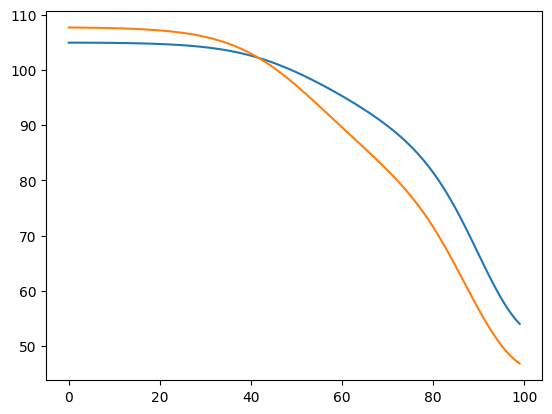

In [48]:
plt.plot(range(len(train_loss)), train_loss);
plt.plot(range(len(val_loss)), val_loss);

# Testing

We have kept the calculation of the test error separate in order to emphasize that you should not use the test set in optimization.

In [49]:
output_test = forward(x_test, NN)

Test loss:  49.228


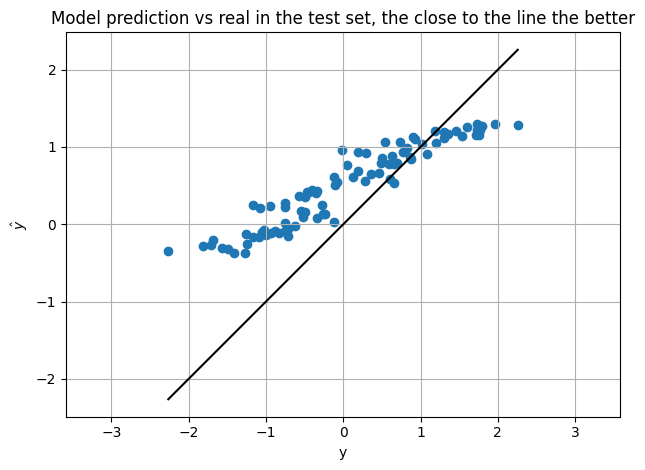

In [50]:
y_test_np = Var_to_nparray(y_test)
plt.scatter(y_test_np, Var_to_nparray(output_test));
plt.plot([np.min(y_test_np), np.max(y_test_np)], [np.min(y_test_np), np.max(y_test_np)], color='k');
plt.xlabel("y");
plt.ylabel("$\hat{y}$");
plt.title("Model prediction vs real in the test set, the close to the line the better")
plt.grid(True);
plt.axis('equal');
plt.tight_layout();

Loss_test = squared_loss(y_test, forward(x_test, NN))

print("Test loss:  {:4.3f}".format(Loss_test.v))

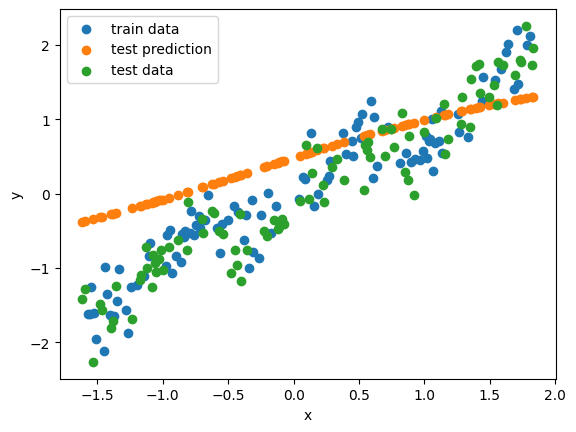

In [51]:
x_test_np = Var_to_nparray(x_test)
x_train_np = Var_to_nparray(x_train)
y_train_np = Var_to_nparray(y_train)
if D1:
    plt.scatter(x_train_np, y_train_np, label="train data");
    plt.scatter(x_test_np, Var_to_nparray(output_test), label="test prediction");
    plt.scatter(x_test_np, y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");
else:
    plt.scatter(x_train_np[:,1], y_train, label="train data");
    plt.scatter(x_test_np[:,1], Var_to_nparray(output_test), label="test data prediction");
    plt.scatter(x_test_np[:,1], y_test_np, label="test data");
    plt.legend();
    plt.xlabel("x");
    plt.ylabel("y");

## Exercise l) Show overfitting, underfitting and just right fitting

Vary the architecture and other things to show clear signs of overfitting (=training loss significantly lower than test loss) and underfitting (=not fitting enoung to training data so that test performance is also hurt).

See also if you can get a good compromise which leads to a low validation loss.

For this problem do you see any big difference between validation and test loss? The answer here will probably be no. Discuss cases where it is important to keep the two separate.


## **Solution to exercise l**

**Overfitting**:
An easy way to overfit the model is to increase the number of training epochs to a high number. In this case, I have increased the number of epochs to 500, and we see that the validation loss becomes much larger than the training loss, which is a clear sign of overfitting. Some clear artifacts from the use of the ReLU activation function, as the model is unable to provide any negative values.

**Underfitting**:
To cause underfitting, we can do a number of things. In the spirit of what we have done in the previous exercise, we can decrease the number of epochs, such that the model doesnt really learn any patterns in the data. Similarly, we can also reduce the learning rate, such that the model practically doesnt converge towards any minima. We could also simplify the model itself, by reducing the number of hidden layers, or the number of nodes in each layer. In this case, I have reduced the number of epochs to 100, and reduced the learning rate by a factor of 10.

**Just right fitting**:
Contrary to the above, "Just-right"-fitting is about balancing the hyper parameters for that specific model, i.e. minimizing training- and validation loss, while also minimizing the difference between training- and validation loss. Working with this NN implementation, there is a tendency to get quite inconsistent results. However, I obtained pretty decent results with the hyperparameters below (with activation function changed from ReLU to tanh). However, with the provided network, I would argue doing linear regression will yield much better results. Also, the validation loss should not be lower than the training loss.

**Validation- and test loss**
The test loss is what is used to tune the model, but the validation is there to indicate what the model picked up general patterns in the data rather than simply learnt the correct output for the test data (overfitting). This is also why it is important to not have exact data matches in each data set. The difference when training the model here is fairly low, although it is odd that the validation loss is lower than the training loss. However, I would argue that this is also due to the simplicity of the sample data.


In [ ]:
# Insert your code for getting overfitting, underfitting and just right fitting

## Overfitting
EPOCHS = 500

## Underfitting
EPOCHS = 100
LEARN_R = 2e-4

## Just right
EPOCH = 100
LEARN_R = 2.5e-3

# Next steps - classification

It is straight forward to extend what we have done to classification.

For numerical stability it is better to make softmax and cross-entropy as one function so we write the cross entropy loss as a function of the logits we talked about last week.

Next week we will see how to perform classification in PyTorch.